# Modeling Our Data - Lab

## Introduction 

In this lab we'll perform a full linear regression on our data. We'll take a stepwise approach and we'll try to improve our model as we go.

## Objectives
You will be able to:

* Remove predictors with p-values too high and refit the model
* Examine and interpret the model results
* Split data into training and testing sets
* Fit a regression model to the data set using statsmodel library


## Build single linear regression models

From the previous steps, it is pretty clear that we have quite a few predictors, but there are some issues with them. Linearity with the target "Weekly_Sales" wasn't apparent. If that's the case, it's always smart to start small, and go ahead and build linear regression models with just one input at the time. Somewhat like what we've done in section 10, let's look at some statistics for single linear regression models for all our *continuous* variables with the outcome.

**Note: for now, we will not use holdout validation, as we're just trying to gauge interpretation and a sense of predictive capacity for each of the candidate predictors**

### Load the cleaned dataset "walmart_dataset.csv", and check its contents 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('walmart_dataset_cleaned.csv')
df.head()

,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Store_1,Store_10,Store_2,...,binned_markdown_4_41-60%,binned_markdown_4_61-80%,binned_markdown_4_81-100%,binned_markdown_4_NaN,binned_markdown_5_0-20%,binned_markdown_5_21-40%,binned_markdown_5_41-60%,binned_markdown_5_61-80%,binned_markdown_5_81-100%,binned_markdown_5_NaN
0,24924.50,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50605.27,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,13740.12,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,39954.04,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,32229.38,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1


Let's pull up the info.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97839 entries, 0 to 97838
Columns: 127 entries, Weekly_Sales to binned_markdown_5_NaN
dtypes: bool(1), float64(6), int64(120)
memory usage: 94.1 MB


Note that the output for info is much smaller compared to what we usually see. Because we have so many columns, pandas is intentionally not showing the data types for each column. Let's use `info()` again, but now just on the first 15 columns of the data.

In [3]:
df.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97839 entries, 0 to 97838
Data columns (total 15 columns):
Weekly_Sales    97839 non-null float64
IsHoliday       97839 non-null bool
Size            97839 non-null float64
Temperature     97839 non-null float64
Fuel_Price      97839 non-null float64
CPI             97839 non-null float64
Unemployment    97839 non-null float64
Store_1         97839 non-null int64
Store_10        97839 non-null int64
Store_2         97839 non-null int64
Store_3         97839 non-null int64
Store_4         97839 non-null int64
Store_5         97839 non-null int64
Store_6         97839 non-null int64
Store_7         97839 non-null int64
dtypes: bool(1), float64(6), int64(8)
memory usage: 10.5 MB


Remember that all the columns from store_1 onwards are actually dummies, so categorical variables. Because we stored the data and loaded it in again, this information was lost. Let's make sure they become categorical again. You can write a for-loop to do this.

In [4]:
for i in df.iloc[:,7:].columns:
    df[i]=df[i].astype('category')

Let's make sure IsHoliday is a categorical variable as well.

In [5]:
df['IsHoliday']=df['IsHoliday'].astype('category')

Let's check the info again to make sure everything is OK now.

In [6]:
df.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97839 entries, 0 to 97838
Data columns (total 15 columns):
Weekly_Sales    97839 non-null float64
IsHoliday       97839 non-null category
Size            97839 non-null float64
Temperature     97839 non-null float64
Fuel_Price      97839 non-null float64
CPI             97839 non-null float64
Unemployment    97839 non-null float64
Store_1         97839 non-null category
Store_10        97839 non-null category
Store_2         97839 non-null category
Store_3         97839 non-null category
Store_4         97839 non-null category
Store_5         97839 non-null category
Store_6         97839 non-null category
Store_7         97839 non-null category
dtypes: category(9), float64(6)
memory usage: 5.3 MB


Great! you should see that the datatypes have changed to categories now! If you use `.describe` now, you should see only the remaining continuous variables in the data set.

In [7]:
df.describe()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment
count,97839.000000,9.783900e+04,9.783900e+04,9.783900e+04,9.783900e+04,9.783900e+04
mean,17223.235591,-8.044340e-14,2.339480e-13,4.784098e-13,-9.181116e-15,1.795967e-12
std,25288.572553,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1098.000000,-1.611999e+00,-3.843452e+00,-1.691961e+00,-1.958762e+00,-2.776898e+00
25%,2336.485000,-1.028620e+00,-7.087592e-01,-1.053793e+00,-1.266966e-01,-6.503157e-01
50%,7658.280000,2.834360e-01,1.340726e-01,1.180741e-01,4.995210e-01,-4.621274e-02
75%,20851.275000,1.113495e+00,8.680410e-01,8.243739e-01,6.346144e-01,7.089160e-01
max,693099.360000,1.171380e+00,1.738375e+00,2.745691e+00,8.517705e-01,2.361469e+00


### Use a for-loop to look at some results for each linear regression model 

Let's use ordinary least squares in statsmodels at this stage.
Import `statsmodels.formula.api` to get started

In [44]:
import statsmodels.formula.api as smf

Create a loop that for each iteration:
* Runs a simple OLS regression between (continuous) independent and dependent variables
* Store following values in array for each iteration
    * Target variable
    * R_squared
    * intercept
    * slope
    * p-value
* Comment on each output 

In [33]:
df2=df
df2=df2.describe().columns.drop(['Weekly_Sales'])
results=[['ind_var','r_squared','intercept','slope','p-value']]
for i in df2:
    f='Weekly_Sales~'+i
    x_min=min(df[i])
    x_max=max(df[i])
    model=smf.ols(formula=f,data=df).fit()
    X_new=pd.DataFrame({i:[x_min,x_max]});
    predictions=model.predict(X_new)
    results.append([i,model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
print(results)

[['ind_var', 'r_squared', 'intercept', 'slope', 'p-value'], ['Size', 0.08577198301194788, 17223.235590817567, 7406.227377928902, 0.0], ['Temperature', 0.0010145286600620196, 17223.23559081738, 805.483179703391, 2.1609858154641024e-23], ['Fuel_Price', 0.0008029403665875678, 17223.23559081723, 716.5821103232356, 7.649612001159469e-19], ['CPI', 0.0394105153543548, 17223.23559081749, -5020.3081203808315, 0.0], ['Unemployment', 0.0008517114683161964, 17223.23559081625, 738.0241329746441, 6.825456986258117e-20]]


In [22]:
# r-squared values are all very low, meaning that these inputs do not explain the output 
# p-value is below the .05 threshold meaning that none of the slopes are zero

In [34]:
pd.DataFrame(results)

,0,1,2,3,4
0,ind_var,r_squared,intercept,slope,p-value
1,Size,0.085772,17223.2,7406.23,0
2,Temperature,0.00101453,17223.2,805.483,2.16099e-23
3,Fuel_Price,0.00080294,17223.2,716.582,7.64961e-19
4,CPI,0.0394105,17223.2,-5020.31,0
5,Unemployment,0.000851711,17223.2,738.024,6.82546e-20


Think about your results. 
- What do the parameter estimates mean? Do they make sense? 
- What do the p-values tell us?
- What does the R-squared tell us?

## Our R-squared values are low, let's try to solve this

Something we haven't considered before, is taking log-transformations to make certain data less skewed. Let's take a quick look at our summarizing histograms. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000299A45B36A0>,
      dtype=object)

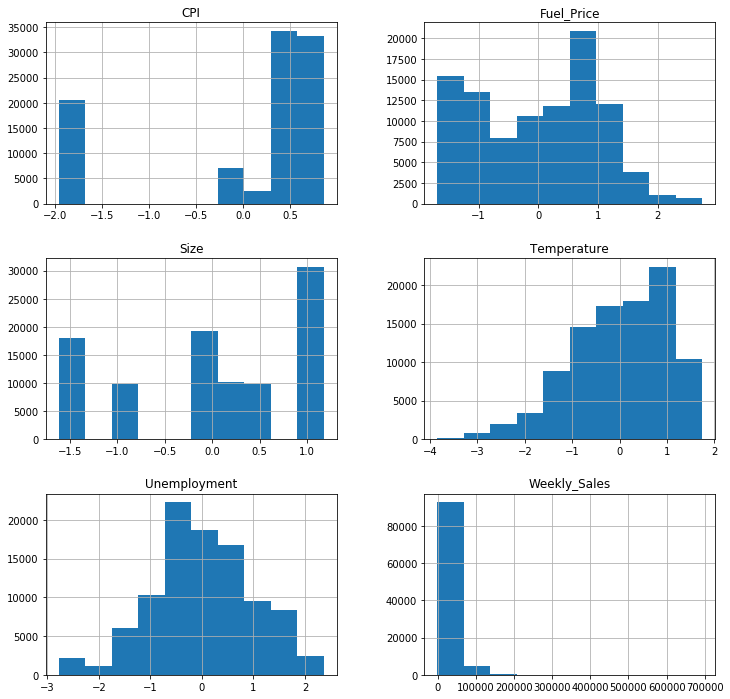

In [24]:
df.hist(figsize=(12,12))

Interestingly the most problematic variable in terms of skewness seems to be weekly sales itself. Does it make sense to log-transform this variable? It definitely doesn't hurt to try! Let's have a look below. what do you see?

In [25]:
np.log(df["Weekly_Sales"]).describe()

C:\Users\kylej\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\kylej\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


count    9.763100e+04
mean             -inf
std               NaN
min              -inf
25%      7.765571e+00
50%      8.948268e+00
75%      9.947998e+00
max      1.344893e+01
Name: Weekly_Sales, dtype: float64

That's right, we have some negative `Weekly_Sales` values! Let's check how many we have.

In [26]:
sum(df.Weekly_Sales<=0)

224

This seems negligibe considering we have almost 100,000 observations. Let's remove these 224 rows so we can take the log.

In [27]:
df_log=df[df['Weekly_Sales']>0]

In [28]:
df_log['Weekly_Sales']=np.log(df_log['Weekly_Sales'])

C:\Users\kylej\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's have another look at the histogram. What do you see?

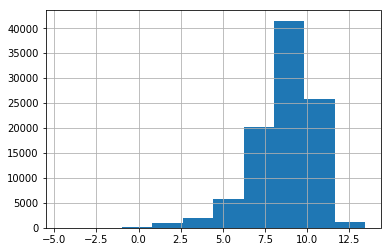

In [29]:
df_log.Weekly_Sales.hist()

Now let's repeat what we did before, yet now with the log(Weekly_Sales) as the target.

In [35]:
results_log=[['ind_var','r_squared','intercept','slope','p-value']]
for i in df2:
    f='Weekly_Sales~'+i
    x_min=min(df_log[i])
    x_max=max(df_log[i])
    model=smf.ols(formula=f,data=df_log).fit()
    X_new=pd.DataFrame({i:[x_min,x_max]});
    predictions=model.predict(X_new)
    results_log.append([i,model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
print(results)

[['ind_var', 'r_squared', 'intercept', 'slope', 'p-value'], ['Size', 0.08577198301194788, 17223.235590817567, 7406.227377928902, 0.0], ['Temperature', 0.0010145286600620196, 17223.23559081738, 805.483179703391, 2.1609858154641024e-23], ['Fuel_Price', 0.0008029403665875678, 17223.23559081723, 716.5821103232356, 7.649612001159469e-19], ['CPI', 0.0394105153543548, 17223.23559081749, -5020.3081203808315, 0.0], ['Unemployment', 0.0008517114683161964, 17223.23559081625, 738.0241329746441, 6.825456986258117e-20]]


In [37]:
pd.DataFrame(results)

,0,1,2,3,4
0,ind_var,r_squared,intercept,slope,p-value
1,Size,0.085772,17223.2,7406.23,0
2,Temperature,0.00101453,17223.2,805.483,2.16099e-23
3,Fuel_Price,0.00080294,17223.2,716.582,7.64961e-19
4,CPI,0.0394105,17223.2,-5020.31,0
5,Unemployment,0.000851711,17223.2,738.024,6.82546e-20


In [36]:
pd.DataFrame(results_log)

,0,1,2,3,4
0,ind_var,r_squared,intercept,slope,p-value
1,Size,0.10781,8.67149,0.611619,0
2,Temperature,0.0007655,8.6716,0.0515691,5.34002e-18
3,Fuel_Price,0.000449281,8.67161,0.0394923,3.51766e-11
4,CPI,0.0259491,8.6717,-0.300207,0
5,Unemployment,0.000276961,8.67162,0.0310137,1.99438e-07


- compare and contract the results with the results obtained when we did not take the log(sales)
- Which one would you want to proceed with based on this?

## Build a model with each categorical variable as a predictor

- Use it on the log-transformed, and the regular `Weekly_Sales`
- put all categories for one categorical variable in 1 model, so we want 4 models.
- remember that we have 4 categorical variables: `Store`,  `Dept`, `IsHoliday` and `Type`( we're for now ignoring the `binned_markdown` categories, you can add then later on as an extension)
- IMPORTANT: remember that we made dummies for `Type`, `Dept` and `Store` columns. You'll need to drop 1 column for each of these if you want good results. The reason for this is that singularity will occur and . This is related to what we mentioned earlier on in section 11. Don't worry about the "why" for now, just make sure to drop 1 column and you should be fine! The parameter value for the dropper "base category" will be absorbed in the intercept.

In [52]:
store_columns=df.columns[7:16]
dept_columns=df.columns[17:95]
type_columns=df.columns[96:97]
holiday=df.columns[1:2]
cols=[store_columns, dept_columns, type_columns, holiday]
results_cat=[['ind_var','r_squared','p-value']]
for i in cols:
    col_names='+'.join(i)    
    f='Weekly_Sales~'+col_names
    model=smf.ols(formula=f,data=df).fit()
    results_cat.append([i,model.rsquared, model.pvalues[1]])

In [53]:
pd.DataFrame(results_cat)

,0,1,2
0,ind_var,r_squared,p-value
1,"Index(['Store_1', 'Store_10', 'Store_2', 'Stor...",0.122607,4.82813e-308
2,"Index(['Dept_1', 'Dept_10', 'Dept_11', 'Dept_1...",0.503035,1.03789e-50
3,"Index(['Type_A'], dtype='object')",0.0495153,0
4,"Index(['IsHoliday'], dtype='object')",0.000215155,4.4693e-06


In [54]:
results_cat_log=[['ind_var','r_squared','p-value']]
for i in cols:
    col_names='+'.join(i)    
    f='Weekly_Sales~'+col_names
    model=smf.ols(formula=f,data=df_log).fit()
    results_cat_log.append([i,model.rsquared, model.pvalues[1]])

In [55]:
pd.DataFrame(results_cat_log)

,0,1,2
0,ind_var,r_squared,p-value
1,"Index(['Store_1', 'Store_10', 'Store_2', 'Stor...",0.127908,4.33189e-259
2,"Index(['Dept_1', 'Dept_10', 'Dept_11', 'Dept_1...",0.623852,0
3,"Index(['Type_A'], dtype='object')",0.067571,0
4,"Index(['IsHoliday'], dtype='object')",9.98557e-05,0.00179552


In [58]:
df_log.tail()

,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Store_1,Store_10,Store_2,...,binned_markdown_4_41-60%,binned_markdown_4_61-80%,binned_markdown_4_81-100%,binned_markdown_4_NaN,binned_markdown_5_0-20%,binned_markdown_5_21-40%,binned_markdown_5_41-60%,binned_markdown_5_61-80%,binned_markdown_5_81-100%,binned_markdown_5_NaN
97834,6.679298,False,-0.120313,0.313984,2.366424,-1.816273,-0.102084,0,1,0,...,0,0,0,0,1,0,0,0,0,0
97835,11.076636,False,-0.120313,0.313984,2.366424,-1.816273,-0.102084,0,1,0,...,0,0,0,0,1,0,0,0,0,0
97836,9.544398,False,-0.120313,0.313984,2.366424,-1.816273,-0.102084,0,1,0,...,0,0,0,0,1,0,0,0,0,0
97837,8.473300,False,-0.120313,0.313984,2.366424,-1.816273,-0.102084,0,1,0,...,0,0,0,0,1,0,0,0,0,0
97838,6.327972,False,-0.120313,0.313984,2.366424,-1.816273,-0.102084,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Let's drop a few columns in our data set based on our findings

- Let's stick with our `walmart_log` data, as it seemed like it was generally resulting in higher R-squared values.
- Let's drop continuous variables which resulted in single linear models with a R-squared value <0.01 for the `walmart_log models`.
- Let's make sure to drop 1 column for each categorical variable we end up using.

In [60]:
df_final=df_log.drop(['Fuel_Price','Unemployment','IsHoliday','Store_10','Dept_99','Type_B'],axis=1)
df_final=df_final.drop(df_final.columns[92:121],axis=1)
df_final.describe()

,Weekly_Sales,Size,Temperature,CPI
count,97615.000000,97615.000000,97615.000000,97615.000000
mean,8.671603,0.000193,-0.000011,0.000335
std,1.863225,1.000262,0.999651,0.999782
min,-4.605170,-1.611999,-3.843452,-1.958762
25%,7.766504,-1.028620,-0.708759,-0.126697
50%,8.948477,0.283436,0.134073,0.499521
75%,9.948167,1.113495,0.868041,0.635046
max,13.448929,1.171380,1.738375,0.851771


## From here on out, use Feature ranking with recursive feature elimination

Let's create a matrix X and y containing the predictors and target for our model. Let's use Scikit-Learn's RFE function, documentation again [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).

In [61]:
y=df_final['Weekly_Sales']
X=df_final.drop(['Weekly_Sales'],axis=1)
X.head()

,Size,Temperature,CPI,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Type_A
0,0.283436,-1.301205,0.40349,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.283436,-1.301205,0.40349,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.283436,-1.301205,0.40349,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.283436,-1.301205,0.40349,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.283436,-1.301205,0.40349,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Let's create a for loop using `RFE` where we look at the 5, 15, 25,... up until 85 best features to be selected according to the feature ranking algorithm. Store the R-squared and the adjusted-R-squareds for all these models in a list. What do you see? No need to perform a train-test-split for now- that will be next!

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [71]:
r_sq=[]
adj_r_sq=[]
n_list=list(range(5,86,10))
for n in n_list:
    selected_n=RFE(linreg,n_features_to_select=n)
    selected_n=selected_n.fit(X,y)
    selected_columns=X.columns[selected_n.support_]
    linreg.fit(X[selected_columns],y)
    yhat=linreg.predict(X[selected_columns])
    ss_res=np.sum((y-yhat)**2)
    ss_total=np.sum((y-np.mean(y))**2)
    r_2=1-(ss_res/ss_total)
    adj_r_2=1-(1-r_2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    r_sq.append(r_2)
    adj_r_sq.append(adj_r_2)
print(n_list,r_sq,adj_r_sq)

[5, 15, 25, 35, 45, 55, 65, 75, 85] [0.07796309689788561, 0.19912098215346719, 0.34770241546296343, 0.45498071805363616, 0.538591822633649, 0.6085856892912109, 0.6616511805081534, 0.7109622948736676, 0.7715440968991327] [0.07710273207951157, 0.19837367135884398, 0.34709374796716375, 0.45447215335959357, 0.5381612765661538, 0.6082204554256151, 0.6613354627536364, 0.7106925899715779, 0.7713309216770602]


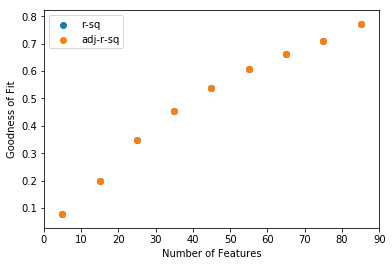

In [75]:
plt.scatter(n_list,r_sq, label='r-sq')
plt.scatter(n_list,adj_r_sq,label='adj-r-sq')
plt.xlabel('Number of Features')
plt.ylabel('Goodness of Fit')
plt.legend()

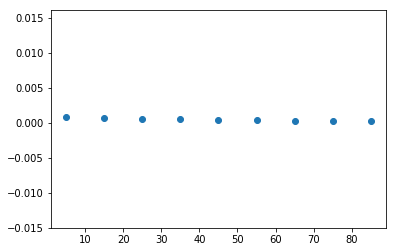

In [78]:
diff=np.array(r_sq)-np.array(adj_r_sq)
plt.scatter(n_list,diff,label='Difference')

The difference between $R^2$ and adjusted $R^2$ is negligible, and seems to continue to be going up as we include more features. Remember though that we're likely overfitting when including 85 features. In order to identify this, let's rerun a similar experiment, but using a train test split!

## Including a train-test-split

Let's create a similar for loop to what we did before. Except, this time
- Use a train test split of 20-80
- Instead of looking at $R^2$ and $R^2_{adj}$, look at the MSE for train and test

In [80]:
from sklearn.model_selection import train_test_split
mse_train=[]
mse_test=[]
n_list_tt=list(range(5,86,10))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3)
for n in n_list:
    selected_n=RFE(linreg,n_features_to_select=n)
    selected_n=selected_n.fit(X_train,y_train)
    selected_columns=X.columns[selected_n.support_]
    linreg.fit(X_train[selected_columns],y_train)
    yhat_train=linreg.predict(X_train[selected_columns])
    yhat_test=linreg.predict(X_test[selected_columns])
    mse_tr=np.sum((y_train-yhat_train)**2)/(len(y_train))
    mse_te=np.sum((y_test-yhat_test)**2)/(len(y_test))   
    mse_train.append(mse_tr)
    mse_test.append(mse_te)
print(n_list,mse_train,mse_test)

[5, 15, 25, 35, 45, 55, 65, 75, 85] [3.1834358072927844, 2.76199341335405, 2.2481120288179826, 1.8971088217616165, 1.587487467689309, 1.3459191006441094, 1.1628186808806118, 0.9926629531946931, 0.787369754661834] [3.270942280447114, 2.8539651380892765, 2.3304941669220165, 1.9590725458473008, 1.659864159723485, 1.4116570043526326, 1.223256007706605, 1.0477950745342162, 0.8173631685551466]


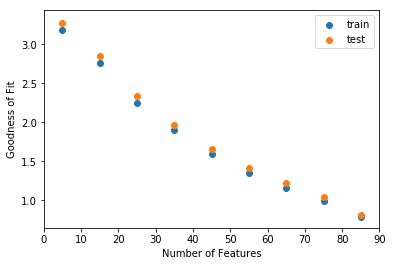

In [81]:
plt.scatter(n_list,mse_train, label='train')
plt.scatter(n_list,mse_test,label='test')
plt.xlabel('Number of Features')
plt.ylabel('Goodness of Fit')
plt.legend()

What we see is that both MSE keeps improving when we add variables. It seems like a bigger model improves our performance, and the test and train performance don't really diverge. It is important to note however that is not an unusual result. The performance measures used typically will show this type of behavior. In order to really be able to balance the curse of dimensionality (which will become more important in machine learning), we need other information criteria such as AIC and BIC. You'll learn about them later! Now, let's perform cross-validation on our model with 85 predictors!

## 10-fold cross validation with the final model

Create a 10-fold cross-validation and store the (negative) MSEs 

In [87]:
n_list_tt2=list(range(5,86,10))
avg_mse_train=[]
avg_mse_test=[]
for n in n_list_tt2:
    mse_train2=[]
    mse_test2=[]
    for i in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        selected_n=RFE(linreg,n_features_to_select=n)
        selected_n=selected_n.fit(X_train,y_train)
        selected_columns=X.columns[selected_n.support_]
        linreg.fit(X_train[selected_columns],y_train)
        yhat_train=linreg.predict(X_train[selected_columns])
        yhat_test=linreg.predict(X_test[selected_columns])
        mse_tr=np.sum((y_train-yhat_train)**2)/(len(y_train))
        mse_te=np.sum((y_test-yhat_test)**2)/(len(y_test))   
        mse_train2.append(mse_tr)
        mse_test2.append(mse_te)
    m1=np.mean(mse_train2)
    m2=np.mean(mse_test2)
    avg_mse_train.append(m1)
    avg_mse_test.append(m2)
print(n_list,avg_mse_train,avg_mse_test)

[5, 15, 25, 35, 45, 55, 65, 75, 85] [3.2051889710557604, 2.7907848242670434, 2.2585909895760303, 1.8966553063728882, 1.6026675553633603, 1.357827425400223, 1.173625591561415, 0.9996793790932219, 0.7910751761205524] [3.18415418003231, 2.7394477455355917, 2.288532192136936, 1.8948439470256613, 1.5989881515925055, 1.353971956281641, 1.1792683804948108, 1.0213402249079668, 0.7978572374025783]


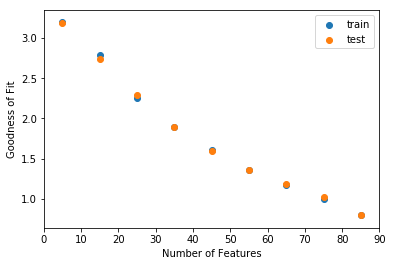

In [88]:
plt.scatter(n_list,avg_mse_train, label='train')
plt.scatter(n_list,avg_mse_test,label='test')
plt.xlabel('Number of Features')
plt.ylabel('Goodness of Fit')
plt.legend()

Running our 10-fold cross-validation highlights some issues for sure! Have a look at your list of 10 MSEs. Where most MSEs are manageable, some are very high. The cure of dimensionality is already pretty clear here. The issue is that we have many (dummy) categorical variables that result in columns with many zeroes and few ones. This means that for some folds, there is a risk of ending up with columns that almost exclusively contain 0's for prediction, which might cause weird results. Looking at this, a model with less predictors might make sense again. This is where we conclude for now. It's up to you now to explore other model options! Additionally, it is encouraged to try some of the "level up" exercises below. Good luck!

# Level up - Optional


- You could argue that **throwing out negative sales figures is problematic**, because these are probably the types of observations a stakeholder would be very interested in knowing. Repeat your analysis, but now, instead of removing the rows with negative sales, replace their sales with a slightly positive value (eg. 1), so they have an existing and finite value. Does the result change?

- Go back and log-transform `CPI` and `Size` before standardizing it (we did this a few lessons ago). Look at the histogram and see if there is an improvement.
- You might have noticed we ignored `binned_markdown` throughout. Add it in the model and see how it changes the results!

- Try other feature selection methods such as stepwise selection and forward selection seen in section 11.


## Summary

Congratulations, you made it to the end of the last section in this module. Now it's time for a big project on multiple linear regression!